# Deep Reinforcement Learning for Ethereum Trading

This notebook implements a paper-based approach for cryptocurrency trading using Deep Reinforcement Learning (DRL). The methodology follows "Reinforcement Learning Pair Trading: A Dynamic Scaling Approach" with significant simplifications to prevent overfitting.

## Structure
1. **Imports** - All required libraries and dependencies
2. **Configuration** - Trading parameters and model settings
3. **Utilities** - Helper functions for data processing
4. **Data Loading & Feature Prep** - Load and prepare ETH price data
5. **Trading Environment** - Custom Gym environment for trading
6. **Model Training** - Build data, environments and train TD3
7. **Evaluation** - Quick model evaluation and metrics
8. **Visualization** - Performance charts and analysis

## Key Features
- **Simplified Signals**: Only 3 values (Position, Z-Score, Zone) vs 32+ complex features
- **Anti-Overfitting**: Paper-based pseudo-spread calculation with z-score normalization
- **Trading Zones**: 5 zones based on z-score thresholds for clear trading signals
- **Enhanced Rewards**: Multi-component reward system to prevent static position problem


In [1]:
# ===================== IMPORTS =====================
# Core libraries
import os
import time
import json
import glob
import numpy as np
import pandas as pd
from datetime import datetime
from enum import Enum
from typing import Dict, Optional, Tuple, Any, List

# Machine Learning & RL
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import TD3, A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement
from stable_baselines3.common.noise import NormalActionNoise

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Set up matplotlib for high-quality plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['figure.dpi'] = 100

print("✅ All imports loaded successfully")


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


✅ All imports loaded successfully


In [2]:
# ===================== CONFIGURATION =====================

# ========== Data Configuration ==========
# Path to preprocessed ETH data with technical indicators
DATA_PATH = "../ETHUSDT_1m_with_indicators.parquet"
TIMESTAMP_COL = "ts"                    # Timestamp column name
PRICE_COL = "close"                     # Price column for trading
OUTPUT_DIR = "./processed_data"         # Directory for processed data

# ========== Signal Generation Parameters (Paper-Based) ==========
# Following "Reinforcement Learning Pair Trading: A Dynamic Scaling Approach"
MA_PERIOD = 60                          # Moving average period for pseudo-spread calculation
WINDOW_SIZE = 120                       # Rolling window for z-score normalization
OPEN_THRESHOLD = 2.0                    # Z-score threshold to open positions (±2.0)
CLOSE_THRESHOLD = 0.5                   # Z-score threshold to close positions (±0.5)

# ========== Trading Parameters ==========
SEED_MONEY = 10000.0                    # Initial portfolio value
FEE_RATE = 0.00005                      # Trading fee (0.005% - reduced from original)
SLIPPAGE = 0.00005                      # Market impact slippage (0.005%)
TRANSACTION_PENALTY = 0.00001           # Additional penalty for position changes

# ========== Environment Parameters ==========
EPISODE_LENGTH = 40320               # Episode length in minutes (28 days)
EPISODE_LENGTH_EVAL = 40320             # Evaluation episode length (28 days)

# ========== Temporal Data Split Parameters ==========
TRAIN_DURATION_MINUTES = 525600         # 1 year of training data (365 * 24 * 60)
TEST_DURATION_MINUTES = 40320           # 1 month of test data (28 * 24 * 60)
MIN_DATA_BUFFER = 200                   # Minimum buffer for signal calculation
RANDOM_SEED = 42                        # Seed for reproducible splits

# ========== Enhanced Reward System Parameters (Superior Design) ==========
# NEW: Incremental action space
INCREMENTAL_STEP_SIZE = 0.3            # Maximum position change per step (smoother trading)
STATIC_DELTA_THRESH = 0.015             # Threshold for detecting static behavior

# Rebalanced reward components (PnL-focused design)
PNL_REWARD_SCALE = 80.0                 # Primary: NAV-normalized PnL reward scale
MOMENTUM_REWARD_SCALE = 0.5             # Secondary: Momentum alignment
ACTIVITY_REWARD_SCALE = 0.1             # Tertiary: Activity incentive
STATIC_PENALTY_BASE = 0.05              # Base penalty for inactivity
STATIC_PENALTY_ESCALATION = 0.2         # Escalation factor for continued inactivity

# Remove zone-based action rewards (let agent learn naturally)
# REMOVED: ACTION_REWARD_SCALE, ZONE_REWARD_MULTIPLIER

# ========== Enhanced Model Training Parameters (Superior Design) ==========
TOTAL_TIMESTEPS = 100000                # Total training timesteps
LEARNING_RATE = 0.0001                  # Smaller LR, match working regime
BATCH_SIZE = 1024                       # Shorter rollout length
GAMMA = 0.99                            # Standard horizon
GAE_LAMBDA = 0.95                       # Standard GAE
ENT_COEF = 0.02                         # Slightly higher exploration
VF_COEF = 0.5                           # Stronger value loss
MAX_GRAD_NORM = 0.5                     # Standard clipping

# ========== TD3 Specific Parameters ==========
BUFFER_SIZE = 1000000                   # Replay buffer size
NOISE_STD = 0.1                         # Action noise standard deviation
TARGET_POLICY_NOISE = 0.2               # Target policy smoothing noise
NOISE_CLIP = 0.5                        # Noise clipping
POLICY_DELAY = 2                        # Policy update frequency
TAU = 0.005                             # Soft update coefficient

# ========== Evaluation Parameters ==========
NUM_EVAL_EPISODES = 20                  # Number of episodes for evaluation
RANDOMIZE_START = True                  # Randomize episode start positions
EVAL_FREQ = 25000                       # Evaluation frequency during training

print("🔧 Configuration loaded:")
print(f"   📊 Signal: MA={MA_PERIOD}, Window={WINDOW_SIZE}, Thresholds=±{OPEN_THRESHOLD}/±{CLOSE_THRESHOLD}")
print(f"   💰 Trading: Fee={FEE_RATE:.5f}, Slippage={SLIPPAGE:.5f}, Initial=${SEED_MONEY:,.0f}")
print(f"   🎯 Rewards: PnLScale={PNL_REWARD_SCALE}, StaticΔ={STATIC_DELTA_THRESH}, Step={INCREMENTAL_STEP_SIZE}")
print(f"   🧠 Training: Steps={TOTAL_TIMESTEPS:,}, LR={LEARNING_RATE}, Episodes={EPISODE_LENGTH} min")


🔧 Configuration loaded:
   📊 Signal: MA=60, Window=120, Thresholds=±2.0/±0.5
   💰 Trading: Fee=0.00005, Slippage=0.00005, Initial=$10,000
   🎯 Rewards: PnLScale=80.0, StaticΔ=0.015, Step=0.3
   🧠 Training: Steps=100,000, LR=0.0001, Episodes=40320 min


In [3]:
# ===================== UTILITIES =====================

class TradingZone(Enum):
    """Trading zones based on z-score thresholds following research paper methodology"""
    LONG_ZONE = 0      # Z-score < -open_threshold (price below MA - buy signal)
    NEUTRAL_LONG = 1   # -open_threshold <= Z-score < -close_threshold  
    CLOSE_ZONE = 2     # -close_threshold <= Z-score <= close_threshold
    NEUTRAL_SHORT = 3  # close_threshold < Z-score <= open_threshold
    SHORT_ZONE = 4     # Z-score > open_threshold (price above MA - sell signal)

def calculate_pseudo_spread(prices: pd.Series, ma_period: int, window_size: int) -> pd.DataFrame:
    """
    Calculate pseudo-spread following research paper methodology.
    
    Args:
        prices: Price series
        ma_period: Moving average period for baseline
        window_size: Rolling window for z-score normalization
    
    Returns:
        DataFrame with price, ma, spread, and z_score columns
    """
    df_signals = pd.DataFrame()
    
    # Step 1: Calculate moving average (pseudo-spread baseline)
    ma = prices.rolling(window=ma_period, min_periods=1).mean()
    
    # Step 2: Calculate spread (price deviation from MA)
    spread = prices - ma
    
    # Step 3: Normalize spread using z-score over rolling window
    spread_mean = spread.rolling(window=window_size, min_periods=1).mean()
    spread_std = spread.rolling(window=window_size, min_periods=1).std()
    z_score = (spread - spread_mean) / (spread_std + 1e-8)  # Avoid division by zero
    z_score = z_score.fillna(0)  # Fill NaN with neutral value
    
    # Store signals
    df_signals['price'] = prices
    df_signals['ma'] = ma
    df_signals['spread'] = spread
    df_signals['z_score'] = z_score
    
    return df_signals

def calculate_trading_zone(z_score: float, open_threshold: float, close_threshold: float) -> int:
    """
    Calculate trading zone based on z-score thresholds.
    
    Args:
        z_score: Current z-score value
        open_threshold: Threshold for opening positions
        close_threshold: Threshold for closing positions
    
    Returns:
        Trading zone integer (0-4)
    """
    if z_score > open_threshold:
        return TradingZone.SHORT_ZONE.value  # Price above MA - sell signal
    elif z_score > close_threshold:
        return TradingZone.NEUTRAL_SHORT.value
    elif z_score >= -close_threshold:
        return TradingZone.CLOSE_ZONE.value  # Near MA - close positions
    elif z_score >= -open_threshold:
        return TradingZone.NEUTRAL_LONG.value
    else:
        return TradingZone.LONG_ZONE.value   # Price below MA - buy signal

def get_zone_name(zone_value: int) -> str:
    """Convert zone integer to readable name"""
    zone_names = {
        TradingZone.LONG_ZONE.value: 'LONG',
        TradingZone.NEUTRAL_LONG.value: 'NEUTRAL_LONG', 
        TradingZone.CLOSE_ZONE.value: 'CLOSE',
        TradingZone.NEUTRAL_SHORT.value: 'NEUTRAL_SHORT',
        TradingZone.SHORT_ZONE.value: 'SHORT'
    }
    return zone_names.get(zone_value, 'UNKNOWN')

def calculate_metrics(portfolio_values: np.ndarray, initial_value: float = SEED_MONEY) -> Dict[str, float]:
    """
    Calculate comprehensive trading metrics.
    
    Args:
        portfolio_values: Array of portfolio values over time
        initial_value: Initial portfolio value
    
    Returns:
        Dictionary of performance metrics
    """
    if len(portfolio_values) == 0:
        return {}
    
    final_value = portfolio_values[-1]
    total_return = (final_value - initial_value) / initial_value
    
    # Calculate returns
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Basic metrics
    metrics = {
        "final_nav": final_value / initial_value,
        "final_value": final_value,
        "total_return": total_return,
        "avg_return": np.mean(returns) if len(returns) > 0 else 0,
        "return_std": np.std(returns) if len(returns) > 0 else 0,
    }
    
    # Sharpe ratio (annualized for minute data)
    if metrics["return_std"] > 0:
        metrics["sharpe"] = metrics["avg_return"] / metrics["return_std"] * np.sqrt(525600)  # 525600 minutes per year
    else:
        metrics["sharpe"] = 0
    
    # Maximum drawdown
    peak = np.maximum.accumulate(portfolio_values)
    drawdown = (portfolio_values - peak) / peak
    metrics["max_drawdown"] = abs(np.min(drawdown))
    
    # Win rate
    wins = np.sum(returns > 0)
    losses = np.sum(returns < 0)
    metrics["win_rate"] = wins / (wins + losses) if (wins + losses) > 0 else 0
    
    # CAGR (simplified for short periods)
    periods = len(portfolio_values)
    if periods > 0:
        metrics["cagr"] = (final_value / initial_value) ** (525600 / periods) - 1
    else:
        metrics["cagr"] = 0
    
    return metrics

def print_metrics(metrics: Dict[str, float], title: str = "Performance Metrics"):
    """Pretty print performance metrics"""
    print(f"\n📊 {title}")
    print("=" * 50)
    print(f"Final NAV:        {metrics['final_nav']:.3f}")
    print(f"Total Return:     {metrics['total_return']:.2%}")
    print(f"Sharpe Ratio:     {metrics['sharpe']:.3f}")
    print(f"Max Drawdown:     {metrics['max_drawdown']:.2%}")
    print(f"Win Rate:         {metrics['win_rate']:.2%}")
    print(f"CAGR:             {metrics['cagr']:.2%}")

def create_temporal_data_split(df: pd.DataFrame, random_seed: Optional[int] = None) -> Tuple[pd.DataFrame, pd.DataFrame, Dict[str, Any]]:
    """
    Create temporal train/test split ensuring training data is always older than test data.
    
    Args:
        df: Full dataset with timestamp column
        random_seed: Seed for reproducible random splits
    
    Returns:
        Tuple of (train_df, test_df, split_info)
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    total_minutes = len(df)
    required_minutes = TRAIN_DURATION_MINUTES + TEST_DURATION_MINUTES + MIN_DATA_BUFFER
    
    print(f"📊 Temporal Data Split Configuration:")
    print(f"   Total data available: {total_minutes:,} minutes ({total_minutes/525600:.1f} years)")
    print(f"   Required for split: {required_minutes:,} minutes")
    print(f"   Training duration: {TRAIN_DURATION_MINUTES:,} minutes (1 year)")
    print(f"   Test duration: {TEST_DURATION_MINUTES:,} minutes (28 days)")
    
    if total_minutes < required_minutes:
        raise ValueError(f"Insufficient data! Need {required_minutes:,} minutes, have {total_minutes:,}")
    
    # Calculate valid start range for training data
    # Must leave enough room for: signal buffer + training + test
    max_train_start = total_minutes - TRAIN_DURATION_MINUTES - TEST_DURATION_MINUTES
    min_train_start = MIN_DATA_BUFFER  # Need buffer for signal calculation
    
    if max_train_start <= min_train_start:
        raise ValueError(f"Not enough data for random splits. Max start: {max_train_start}, Min start: {min_train_start}")
    
    # Randomly select training start point
    train_start_idx = np.random.randint(min_train_start, max_train_start)
    train_end_idx = train_start_idx + TRAIN_DURATION_MINUTES
    test_start_idx = train_end_idx  # Test starts immediately after training ends
    test_end_idx = test_start_idx + TEST_DURATION_MINUTES
    
    # Create splits
    train_df = df.iloc[train_start_idx:train_end_idx].copy().reset_index(drop=True)
    test_df = df.iloc[test_start_idx:test_end_idx].copy().reset_index(drop=True)
    
    # Calculate date ranges for reporting
    train_start_date = pd.to_datetime(df.iloc[train_start_idx][TIMESTAMP_COL], unit='s')
    train_end_date = pd.to_datetime(df.iloc[train_end_idx-1][TIMESTAMP_COL], unit='s')
    test_start_date = pd.to_datetime(df.iloc[test_start_idx][TIMESTAMP_COL], unit='s')
    test_end_date = pd.to_datetime(df.iloc[test_end_idx-1][TIMESTAMP_COL], unit='s')
    
    split_info = {
        'train_start_idx': train_start_idx,
        'train_end_idx': train_end_idx,
        'test_start_idx': test_start_idx,
        'test_end_idx': test_end_idx,
        'train_start_date': train_start_date,
        'train_end_date': train_end_date,
        'test_start_date': test_start_date,
        'test_end_date': test_end_date,
        'train_duration_days': TRAIN_DURATION_MINUTES / (24 * 60),
        'test_duration_days': TEST_DURATION_MINUTES / (24 * 60),
        'random_seed': random_seed
    }
    
    print(f"✅ Temporal Split Created:")
    print(f"   🎲 Random seed: {random_seed}")
    print(f"   📈 Training: {train_start_date.strftime('%Y-%m-%d')} to {train_end_date.strftime('%Y-%m-%d')} ({len(train_df):,} minutes)")
    print(f"   🧪 Testing:  {test_start_date.strftime('%Y-%m-%d')} to {test_end_date.strftime('%Y-%m-%d')} ({len(test_df):,} minutes)")
    print(f"   ⏰ Gap between train/test: 0 minutes (immediate succession)")
    print(f"   📊 Training uses {len(train_df)/total_minutes:.1%} of total data")
    
    return train_df, test_df, split_info    

def generate_multiple_splits(df: pd.DataFrame, num_splits: int = 5) -> List[Tuple[pd.DataFrame, pd.DataFrame, Dict[str, Any]]]:
    """
    Generate multiple random temporal splits for robust evaluation.
    
    Args:
        df: Full dataset
        num_splits: Number of different random splits to generate
    
    Returns:
        List of (train_df, test_df, split_info) tuples
    """
    splits = []
    for i in range(num_splits):
        seed = RANDOM_SEED + i * 1000  # Ensure different seeds
        train_df, test_df, split_info = create_temporal_data_split(df, random_seed=seed)
        splits.append((train_df, test_df, split_info))
        print(f"   Split {i+1}/{num_splits}: {split_info['train_start_date'].strftime('%Y-%m-%d')} to {split_info['test_end_date'].strftime('%Y-%m-%d')}")
    
    return splits

# ========== Enhanced Utility Functions (Superior Design) ==========

def calculate_portfolio_performance(current_value: float, initial_value: float) -> float:
    """Calculate normalized portfolio performance"""
    return (current_value - initial_value) / initial_value

def calculate_unrealized_pnl(position: float, entry_price: float, current_price: float, portfolio_value: float) -> float:
    """Calculate unrealized PnL as percentage of portfolio"""
    if abs(position) < 1e-6 or entry_price <= 0:
        return 0.0
    
    price_change = (current_price - entry_price) / entry_price
    position_pnl = position * price_change
    return position_pnl * 0.01  # Normalize to portfolio scale

def calculate_recent_volatility(prices: np.ndarray, current_idx: int, window: int = 60) -> float:
    """Calculate recent price volatility"""
    start_idx = max(0, current_idx - window + 1)
    end_idx = min(current_idx + 1, len(prices))
    
    if end_idx - start_idx < 2:
        return 0.0
    
    price_window = prices[start_idx:end_idx]
    returns = np.diff(price_window) / price_window[:-1]
    return float(np.std(returns)) if len(returns) > 0 else 0.0

def smooth_action_transition(current_position: float, target_action: float, step_size: float) -> float:
    """Convert action to smooth incremental position change"""
    # Scale action to incremental step
    position_delta = target_action * step_size
    
    # Apply to current position with bounds
    new_position = np.clip(current_position + position_delta, -1.0, 1.0)
    return new_position

print("✅ Enhanced utility functions loaded:")


✅ Enhanced utility functions loaded:


In [4]:
# ===================== DATA LOADING & FEATURE PREPARATION =====================

def load_and_process_data(data_path: str) -> Tuple[pd.DataFrame, pd.DataFrame, list, Dict[str, Any]]:
    """
    Load ETH data and process with paper-based signal generation.
    
    Args:
        data_path: Path to the parquet file
    
    Returns:
        Tuple of (train_df, test_df, feature_columns, split_info)
    """
    print(f"📁 Loading data from: {data_path}")
    
    # Check if file exists
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Data file not found: {data_path}")
    
    # Load data
    df = pd.read_parquet(data_path)
    print(f"   🔍 Available columns: {list(df.columns)}")
    print(f"   🔍 Index name: {df.index.name}")
    print(f"   🔍 Index type: {type(df.index)}")
    
    # Reset index if timestamp is in index (common with processed data)
    if df.index.name == 'ts' or 'ts' in str(df.index.name):
        df = df.reset_index()
    
    df.columns = df.columns.str.strip()
    
    # Check if timestamp column exists, if not try to find it
    if TIMESTAMP_COL not in df.columns:
        possible_ts_cols = ['timestamp', 'ts', 'time', 'date', 'datetime']
        for col in possible_ts_cols:
            if col in df.columns:
                print(f"   🔧 Found timestamp column: '{col}', renaming to '{TIMESTAMP_COL}'")
                df = df.rename(columns={col: TIMESTAMP_COL})
                break
        else:
            # If still not found, check if index is datetime-like
            if pd.api.types.is_datetime64_any_dtype(df.index):
                print(f"   🔧 Using index as timestamp column")
                df = df.reset_index()
                df = df.rename(columns={df.columns[0]: TIMESTAMP_COL})
            else:
                raise ValueError(f"Could not find timestamp column. Available columns: {list(df.columns)}")
    
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    
    # Clean price data
    df[PRICE_COL] = pd.to_numeric(df[PRICE_COL], errors='coerce')
    df = df.dropna(subset=[PRICE_COL])
    df = df[df[PRICE_COL] > 0]
    
    print(f"   📊 Data loaded: {len(df):,} rows")
    print(f"   📅 Date range: {pd.to_datetime(df[TIMESTAMP_COL], unit='s').min()} to {pd.to_datetime(df[TIMESTAMP_COL], unit='s').max()}")
    
    # ========== PAPER-BASED SIGNAL GENERATION ==========
    print("   🔬 Generating paper-based signals...")
    
    # Calculate pseudo-spread signals
    signals_df = calculate_pseudo_spread(df[PRICE_COL], MA_PERIOD, WINDOW_SIZE)
    
    # Calculate trading zones
    signals_df['zone'] = signals_df['z_score'].apply(
        lambda x: calculate_trading_zone(x, OPEN_THRESHOLD, CLOSE_THRESHOLD)
    )
    
    # Add zone names for readability
    signals_df['zone_name'] = signals_df['zone'].apply(get_zone_name)
    
    # Merge signals back to dataframe
    df = pd.concat([df.reset_index(drop=True), signals_df.reset_index(drop=True)], axis=1)
    
    # Show signal statistics
    print(f"      Z-score range: [{signals_df['z_score'].min():.2f}, {signals_df['z_score'].max():.2f}]")
    
    # Zone distribution
    zone_counts = df['zone_name'].value_counts()
    print(f"      Zone distribution:")
    for zone, count in zone_counts.items():
        print(f"        {zone}: {count:,} ({count/len(df)*100:.1f}%)")
    
    # ========== TEMPORAL TRAIN/TEST SPLIT ==========
    print(f"   ✂️ Creating temporal data split...")
    
    # Create temporal split ensuring training data is older than test data
    train_df, test_df, split_info = create_temporal_data_split(df, random_seed=RANDOM_SEED)
    
    # ========== FEATURE SELECTION ==========
    # Paper-based approach: Only essential signals (vs 32+ complex features)
    feature_cols = ['z_score', 'zone']
    
    print(f"   🎯 Features: {feature_cols} (simplified from 32+ to 2)")
    
    # Verify data quality
    for col in feature_cols:
        train_nulls = train_df[col].isnull().sum()
        test_nulls = test_df[col].isnull().sum()
        if train_nulls > 0 or test_nulls > 0:
            print(f"      ⚠️ Warning: {col} has {train_nulls} train nulls, {test_nulls} test nulls")
    
    print("✅ Data processing complete!")
    return train_df, test_df, feature_cols, split_info

# Load and process the data
train_df, test_df, feature_cols, split_info = load_and_process_data(DATA_PATH)

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Export processed data for reference
export_cols = [TIMESTAMP_COL, PRICE_COL] + feature_cols + ['zone_name']
train_path = os.path.join(OUTPUT_DIR, "train_processed.csv")
test_path = os.path.join(OUTPUT_DIR, "test_processed.csv")

train_df[export_cols].to_csv(train_path, index=False, float_format="%.6f")
test_df[export_cols].to_csv(test_path, index=False, float_format="%.6f")

print(f"💾 Processed data exported to: {OUTPUT_DIR}")
print(f"   📁 Files: train_processed.csv ({len(train_df):,} rows), test_processed.csv ({len(test_df):,} rows)")

# Save split information for reproducibility
split_info_path = os.path.join(OUTPUT_DIR, "split_info.json")
import json
with open(split_info_path, 'w') as f:
    # Convert datetime objects to strings for JSON serialization
    split_info_serializable = split_info.copy()
    for key in ['train_start_date', 'train_end_date', 'test_start_date', 'test_end_date']:
        if key in split_info_serializable:
            split_info_serializable[key] = split_info_serializable[key].isoformat()
    json.dump(split_info_serializable, f, indent=2)

print(f"   📊 Split info saved to: split_info.json")
print(f"   🎲 Random seed used: {split_info['random_seed']} (for reproducibility)")


📁 Loading data from: ../ETHUSDT_1m_with_indicators.parquet
   🔍 Available columns: ['open', 'high', 'low', 'close', 'volume', 'number_of_trades', 'symbol', 'RSI', 'BB_mid', 'BB_high', 'BB_low', 'EMA_12', 'EMA_26', 'MACD', 'MACD_signal', 'MACD_diff', 'ATR']
   🔍 Index name: ts
   🔍 Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
   📊 Data loaded: 1,928,080 rows
   📅 Date range: 2022-01-01 00:00:00+00:00 to 2025-08-31 23:59:00+00:00
   🔬 Generating paper-based signals...
      Z-score range: [-10.32, 10.36]
      Zone distribution:
        NEUTRAL_LONG: 582,263 (30.2%)
        CLOSE: 582,227 (30.2%)
        NEUTRAL_SHORT: 579,862 (30.1%)
        LONG: 95,065 (4.9%)
        SHORT: 88,663 (4.6%)
   ✂️ Creating temporal data split...
📊 Temporal Data Split Configuration:
   Total data available: 1,928,080 minutes (3.7 years)
   Required for split: 566,120 minutes
   Training duration: 525,600 minutes (1 year)
   Test duration: 40,320 minutes (28 days)
✅ Temporal Split Creat

In [5]:
# ===================== ENHANCED TRADING ENVIRONMENT (Superior Design) =====================

class EnhancedTradingEnvironment(gym.Env):
    """
    Enhanced Trading Environment with Superior Design Patterns.
    
    Key Features (Superior Design):
    - Incremental action space (smoother staircase moves)
    - PnL-focused reward system (removed zone-based action rewards)
    - Enhanced state space with PnL tracking and volatility
    - Activity incentives with refined static penalties
    - Improved A2C hyperparameters for stable training
    """
    
    metadata = {"render_modes": []}
    
    def __init__(self, df: pd.DataFrame, feature_cols: list, episode_length: int = EPISODE_LENGTH, 
                 randomize_start: bool = True, seed_money: float = SEED_MONEY,
                 increment_step_size: float = INCREMENTAL_STEP_SIZE,
                 pnl_reward_scale: float = PNL_REWARD_SCALE,
                 static_delta_thresh: float = STATIC_DELTA_THRESH):
        """
        Initialize trading environment.
        
        Args:
            df: DataFrame with price and feature data
            feature_cols: List of feature column names
            episode_length: Episode length in minutes
            randomize_start: Whether to randomize episode start positions
            seed_money: Initial portfolio value
        """
        super().__init__()
        
        # Store data and parameters
        self.df = df.copy()
        self.feature_cols = feature_cols
        self.episode_length = episode_length
        self.randomize_start = randomize_start
        self.seed_money = seed_money
        # Exposed knobs
        self.increment_step_size = float(increment_step_size)
        self.pnl_reward_scale = float(pnl_reward_scale)
        self.static_delta_thresh = float(static_delta_thresh)
        
        # Cache arrays for faster access
        self.prices = self.df[PRICE_COL].values
        self.z_scores = self.df['z_score'].values
        self.zones = self.df['zone'].values
        
        # Episode bounds (ensure enough data for signals)
        self.min_start = max(MA_PERIOD, WINDOW_SIZE)
        self.max_start = len(self.df) - episode_length - 1
        
        # Action space: [-1, 1] for incremental position adjustments
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        
        # Enhanced observation space: [position, z_score, zone, unrealized_pnl, portfolio_performance, 
        #                             volatility, price_momentum, z_momentum, position_change]
        self.observation_space = spaces.Box(
            low=np.array([-1.0, -5.0, 0.0, -0.5, -1.0, 0.0, -0.1, -2.0, -0.1], dtype=np.float32),
            high=np.array([1.0, 5.0, 4.0, 0.5, 1.0, 0.1, 0.1, 2.0, 0.1], dtype=np.float32),
            dtype=np.float32
        )
        
        # State tracking for anti-static penalties
        self.position_history = []
        self.static_steps = 0
        
        # Episode state variables
        self.current_step = None
        self.episode_start = None
        self.position = None
        self.portfolio_value = None
        self.cash = None
        self.shares = None
        
        # Enhanced tracking for superior design
        self.entry_price = None  # Price when position was entered
        self.last_position_change_step = 0  # For activity tracking
        
    def _get_observation(self) -> np.ndarray:
        """Enhanced observation with PnL tracking and volatility (Superior Design)"""
        # Ensure we don't go out of bounds
        current_step = min(self.current_step, len(self.z_scores) - 1)
        
        # Basic signals
        position = float(self.position)
        z_score = float(self.z_scores[current_step])
        zone = float(self.zones[current_step])
        
        # NEW: Enhanced features for superior design
        current_price = self.prices[current_step] if current_step < len(self.prices) else self.prices[-1]
        
        # Unrealized PnL tracking
        unrealized_pnl = calculate_unrealized_pnl(
            position=self.position,
            entry_price=self.entry_price if self.entry_price else current_price,
            current_price=current_price,
            portfolio_value=self.portfolio_value
        )
        unrealized_pnl = np.clip(unrealized_pnl, -0.5, 0.5)
        
        # Portfolio performance
        portfolio_performance = calculate_portfolio_performance(self.portfolio_value, self.seed_money)
        portfolio_performance = np.clip(portfolio_performance, -1.0, 1.0)
        
        # Market volatility
        volatility = calculate_recent_volatility(self.prices, current_step, window=60)
        volatility = np.clip(volatility, 0.0, 0.1)
        
        # Momentum indicators (improved)
        price_momentum = 0.0
        z_momentum = 0.0
        position_change = 0.0
        
        if current_step > 0:
            # Price momentum (short-term price change)
            prev_step = min(current_step - 1, len(self.prices) - 1)
            if current_step < len(self.prices):
                price_momentum = (self.prices[current_step] - self.prices[prev_step]) / self.prices[prev_step]
                price_momentum = np.clip(price_momentum, -0.1, 0.1)
            
            # Z-score momentum (change in signal strength)
            z_momentum = self.z_scores[current_step] - self.z_scores[prev_step]
            z_momentum = np.clip(z_momentum, -2.0, 2.0)
            
            # Position change from last step (incremental)
            if len(self.position_history) > 0:
                position_change = position - self.position_history[-1]
                position_change = np.clip(position_change, -0.1, 0.1)  # Smaller range for incremental
        
        return np.array([
            position,              # Current position
            z_score,              # Current z-score signal  
            zone,                 # Current trading zone
            unrealized_pnl,       # NEW: Unrealized PnL
            portfolio_performance, # NEW: Portfolio performance
            volatility,           # NEW: Market volatility
            price_momentum,       # Price momentum
            z_momentum,           # Signal momentum
            position_change       # Position change (incremental)
        ], dtype=np.float32)
    
    def _calculate_enhanced_rewards(self, action: float) -> Tuple[float, Dict[str, float]]:
        """Enhanced reward system with PnL focus (Superior Design)"""
        
        # Ensure we don't go out of bounds
        current_step = min(self.current_step, len(self.prices) - 1)
        
        # Calculate incremental position change
        new_position = smooth_action_transition(self.position, action, self.increment_step_size)
        actual_position_change = abs(new_position - self.position)
        
        # 1. PRIMARY: PnL Reward (main driver, NAV-normalized)
        pnl_reward = 0.0
        if current_step + 1 < len(self.prices):
            old_value = float(self.portfolio_value)
            price_return = (self.prices[current_step + 1] - self.prices[current_step]) / self.prices[current_step]
            position_return = self.position * price_return
            # NAV-normalized reward magnitude
            pnl_reward = ((old_value * (1 + position_return)) - old_value) / max(old_value, 1e-8)
            pnl_reward *= self.pnl_reward_scale
        
        # 2. SECONDARY: Momentum Alignment Reward
        momentum_reward = 0.0
        if current_step > 0:
            prev_step = min(current_step - 1, len(self.prices) - 1)
            price_momentum = (self.prices[current_step] - self.prices[prev_step]) / self.prices[prev_step]
            
            # Reward taking positions in direction of momentum
            if (new_position > self.position and price_momentum > 0) or (new_position < self.position and price_momentum < 0):
                momentum_reward = MOMENTUM_REWARD_SCALE * actual_position_change * abs(price_momentum)
        
        # 3. TERTIARY: Activity Incentive (refined anti-static)
        activity_reward = 0.0
        
        # Base activity reward for any position change
        if actual_position_change > self.static_delta_thresh:
            activity_reward = ACTIVITY_REWARD_SCALE * actual_position_change
            self.static_steps = 0  # Reset static counter
        else:
            # Escalating penalty for static behavior
            self.static_steps += 1
            static_penalty = -STATIC_PENALTY_BASE * (1 + STATIC_PENALTY_ESCALATION * self.static_steps)
            activity_reward = static_penalty
        
        # 4. COSTS: Transaction costs (no additional penalty)
        transaction_cost = 0.0
        if actual_position_change > 1e-6:
            trading_cost = actual_position_change * (FEE_RATE + SLIPPAGE) * self.portfolio_value
            transaction_cost = -trading_cost
        
        # Total reward (PnL-focused design)
        total_reward = pnl_reward + momentum_reward + activity_reward + transaction_cost
        
        # Enhanced reward breakdown
        reward_breakdown = {
            'pnl_reward': pnl_reward,
            'momentum_reward': momentum_reward,
            'activity_reward': activity_reward,
            'transaction_cost': transaction_cost,
            'position_change': actual_position_change,
            'static_steps': self.static_steps,
            'total_reward': total_reward
        }
        
        return total_reward, reward_breakdown
    
    def _update_portfolio(self, action: float):
        """Enhanced portfolio update with incremental actions and entry price tracking"""
        # Apply incremental action
        new_position = smooth_action_transition(self.position, action, self.increment_step_size)
        position_change = new_position - self.position
        
        # Update position history for tracking
        self.position_history.append(self.position)
        if len(self.position_history) > 10:  # Keep last 10 positions
            self.position_history.pop(0)
        
        if abs(position_change) > 1e-6:
            current_step = min(self.current_step, len(self.prices) - 1)
            current_price = self.prices[current_step]
            
            # Track entry price for new or significantly changed positions
            if abs(self.position) < 0.1 and abs(new_position) > 0.1:
                # Entering new position
                self.entry_price = current_price
            elif (self.position > 0 and new_position < 0) or (self.position < 0 and new_position > 0):
                # Switching sides
                self.entry_price = current_price
            
            # Calculate trade costs
            trade_value = abs(position_change) * self.portfolio_value
            trade_cost = trade_value * (FEE_RATE + SLIPPAGE)
            
            # Update position
            self.position = new_position
            target_equity_value = self.position * self.portfolio_value
            self.shares = target_equity_value / current_price if current_price > 0 else 0
            self.cash = self.portfolio_value - target_equity_value - trade_cost
        else:
            self.position = new_position
        
        # Update portfolio value
        if self.current_step + 1 < len(self.prices):
            next_price = self.prices[self.current_step + 1]
            equity_value = self.shares * next_price
            self.portfolio_value = self.cash + equity_value
    
    def reset(self, seed: Optional[int] = None, options: Optional[Dict] = None) -> Tuple[np.ndarray, Dict]:
        """Reset environment for new episode"""
        super().reset(seed=seed)
        
        # Random episode start if enabled
        if self.randomize_start:
            self.episode_start = self.np_random.integers(self.min_start, self.max_start)
        else:
            self.episode_start = self.min_start
        
        self.current_step = self.episode_start
        self.position = 0.0
        self.portfolio_value = self.seed_money
        self.cash = self.seed_money
        self.shares = 0.0
        
        # Reset enhanced tracking variables
        self.position_history = []
        self.static_steps = 0
        self.entry_price = None
        self.last_position_change_step = 0
        
        observation = self._get_observation()
        info = {
            "portfolio_value": self.portfolio_value,
            "position": self.position,
            "nav": self.portfolio_value / self.seed_money
        }
        
        return observation, info
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        """Execute one trading step"""
        
        # Handle action input
        if np.isscalar(action):
            action_value = float(np.clip(action, -1.0, 1.0))
        else:
            action_value = float(np.clip(action[0], -1.0, 1.0))
        
        # Check episode bounds
        if self.current_step >= self.episode_start + self.episode_length:
            observation = self._get_observation()
            info = {
                "portfolio_value": self.portfolio_value,
                "position": self.position,
                "nav": self.portfolio_value / self.seed_money
            }
            return observation, 0.0, True, False, info
        
        # Calculate enhanced rewards
        total_reward, reward_breakdown = self._calculate_enhanced_rewards(action_value)
        
        # Update portfolio
        self._update_portfolio(action_value)
        
        # Move to next step
        self.current_step += 1
        terminated = self.current_step >= self.episode_start + self.episode_length
        
        # Get next observation
        observation = self._get_observation()
        
        info = {
            "portfolio_value": float(self.portfolio_value),
            "position": float(self.position),
            "nav": float(self.portfolio_value / self.seed_money),
            "static_steps": int(self.static_steps),
            **{k: float(v) for k, v in reward_breakdown.items()}
        }
        
        return observation, total_reward, terminated, False, info

print("✅ Trading environment class created")


✅ Trading environment class created


In [6]:
# ===================== MODEL TRAINING =====================

def create_enhanced_training_environment(
    increment_step_size: float = INCREMENTAL_STEP_SIZE,
    pnl_reward_scale: float = PNL_REWARD_SCALE,
    static_delta_thresh: float = STATIC_DELTA_THRESH,
):
    """Create vectorized enhanced training environment"""
    def make_env():
        return Monitor(EnhancedTradingEnvironment(
            df=train_df,
            feature_cols=feature_cols,
            episode_length=EPISODE_LENGTH,
            randomize_start=RANDOMIZE_START,
            seed_money=SEED_MONEY,
            increment_step_size=increment_step_size,
            pnl_reward_scale=pnl_reward_scale,
            static_delta_thresh=static_delta_thresh
        ))
    return DummyVecEnv([make_env])

def create_enhanced_evaluation_environment(
    increment_step_size: float = INCREMENTAL_STEP_SIZE,
    pnl_reward_scale: float = PNL_REWARD_SCALE,
    static_delta_thresh: float = STATIC_DELTA_THRESH,
):
    """Create vectorized enhanced evaluation environment"""
    def make_env():
        return Monitor(EnhancedTradingEnvironment(
            df=test_df,
            feature_cols=feature_cols,
            episode_length=EPISODE_LENGTH_EVAL,
            randomize_start=False,  # Fixed start for consistent evaluation
            seed_money=SEED_MONEY,
            increment_step_size=increment_step_size,
            pnl_reward_scale=pnl_reward_scale,
            static_delta_thresh=static_delta_thresh
        ))
    return DummyVecEnv([make_env])

# Legacy environments for comparison (fallback to EnhancedTradingEnvironment if missing)
def create_training_environment():
    """Create vectorized training environment (original or fallback)"""
    EnvClass = globals().get('TradingEnvironment', EnhancedTradingEnvironment)
    def make_env():
        return Monitor(EnvClass(
            df=train_df,
            feature_cols=feature_cols,
            episode_length=EPISODE_LENGTH,
            randomize_start=RANDOMIZE_START,
            seed_money=SEED_MONEY
        ))
    return DummyVecEnv([make_env])

def create_evaluation_environment():
    """Create vectorized evaluation environment (original or fallback)"""
    EnvClass = globals().get('TradingEnvironment', EnhancedTradingEnvironment)
    def make_env():
        return Monitor(EnvClass(
            df=test_df,
            feature_cols=feature_cols,
            episode_length=EPISODE_LENGTH_EVAL,
            randomize_start=False,  # Fixed start for consistent evaluation
            seed_money=SEED_MONEY
        ))
    return DummyVecEnv([make_env])

def train_td3_model():
    """
    Train TD3 model with optimized parameters for cryptocurrency trading.
    TD3 is chosen for its stability and sample efficiency compared to other algorithms.
    """
    print("🚀 Training TD3 Model")
    print("=" * 50)
    
    # Create training environment
    print("   🏗️ Creating training environment...")
    train_env = create_training_environment()
    
    # Action noise for exploration (important for TD3)
    action_noise = NormalActionNoise(
        mean=np.zeros(1), 
        sigma=NOISE_STD * np.ones(1)
    )
    
    print(f"   🔧 TD3 Configuration:")
    print(f"      Learning Rate: {LEARNING_RATE}")
    print(f"      Buffer Size: {BUFFER_SIZE:,}")
    print(f"      Action Noise Std: {NOISE_STD}")
    print(f"      Target Policy Noise: {TARGET_POLICY_NOISE}")
    print(f"      Policy Delay: {POLICY_DELAY}")
    print(f"      Batch Size: {BATCH_SIZE}")
    
    # Create TD3 model
    model = TD3(
        policy="MlpPolicy",
        env=train_env,
        learning_rate=LEARNING_RATE,
        buffer_size=BUFFER_SIZE,
        learning_starts=1000,  # Start learning after collecting some experience
        batch_size=BATCH_SIZE,
        tau=TAU,
        gamma=GAMMA,
        train_freq=1,
        gradient_steps=1,
        action_noise=action_noise,
        target_policy_noise=TARGET_POLICY_NOISE,
        target_noise_clip=NOISE_CLIP,
        policy_delay=POLICY_DELAY,
        verbose=1,
        seed=42,
        device='auto'
    )
    
    print(f"   ⏱️ Training for {TOTAL_TIMESTEPS:,} timesteps...")
    start_time = time.time()
    
    # Train the model
    model.learn(total_timesteps=TOTAL_TIMESTEPS)
    
    training_time = (time.time() - start_time) / 60
    print(f"   ✅ Training complete! Time: {training_time:.1f} minutes")
    
    # Save model
    model_path = os.path.join(OUTPUT_DIR, "td3_eth_trading_model")
    model.save(model_path)
    print(f"   💾 Model saved to: {model_path}")
    
    return model

def train_enhanced_a2c_model():
    """
    Train Enhanced A2C model with superior design patterns.
    Uses improved hyperparameters, PnL-focused rewards, and incremental actions.
    """
    print("🚀 Training Enhanced A2C Model (Superior Design)")
    print("=" * 60)
    
    # Create enhanced training environment
    print("   🏗️ Creating enhanced training environment...")
    train_env = create_enhanced_training_environment()
    
    print(f"   🔧 Enhanced A2C Configuration:")
    print(f"      Learning Rate: {LEARNING_RATE} (reduced for stability)")
    print(f"      N-Steps: {BATCH_SIZE} (increased batch size)")
    print(f"      Gamma: {GAMMA} (longer time horizon)")
    print(f"      GAE Lambda: {GAE_LAMBDA} (better advantage estimation)")
    print(f"      Entropy Coef: {ENT_COEF} (reduced exploration)")
    print(f"      Value Function Coef: {VF_COEF} (reduced VF weight)")
    print(f"      Max Grad Norm: {MAX_GRAD_NORM} (tighter clipping)")
    
    # Create Enhanced A2C model aligned with working regime
    model = A2C(
        policy="MlpPolicy",
        env=train_env,
        learning_rate=LEARNING_RATE,
        n_steps=BATCH_SIZE,
        gamma=GAMMA,
        gae_lambda=GAE_LAMBDA,
        ent_coef=ENT_COEF,
        vf_coef=VF_COEF,
        max_grad_norm=MAX_GRAD_NORM,
        verbose=1,
        seed=42,
        device='auto'
    )
    
    print(f"   ⏱️ Training for {TOTAL_TIMESTEPS:,} timesteps...")
    print(f"   🎯 Key improvements: NAV-normalized rewards, incremental actions, enhanced state space")
    start_time = time.time()
    
    # Evaluation callback for early stopping & best model
    eval_env = create_enhanced_evaluation_environment()
    early_stop = StopTrainingOnNoModelImprovement(max_no_improvement_evals=3, min_evals=3, verbose=1)
    eval_cb = EvalCallback(
        eval_env,
        best_model_save_path=OUTPUT_DIR,
        log_path=OUTPUT_DIR,
        eval_freq=EVAL_FREQ,
        n_eval_episodes=5,
        deterministic=True,
        render=False,
        callback_after_eval=early_stop
    )
    
    # Train the model
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=eval_cb)
    
    training_time = (time.time() - start_time) / 60
    print(f"   ✅ Enhanced training complete! Time: {training_time:.1f} minutes")
    
    # Save model
    model_path = os.path.join(OUTPUT_DIR, "enhanced_a2c_eth_trading_model")
    model.save(model_path)
    print(f"   💾 Enhanced model saved to: {model_path}")
    
    return model

def train_a2c_model():
    """
    Train A2C model as alternative/comparison to TD3 (Original Design).
    A2C is faster to train and often performs well on trading tasks.
    """
    print("🚀 Training A2C Model (Original Design)")
    print("=" * 50)
    
    # Create training environment
    print("   🏗️ Creating training environment...")
    train_env = create_training_environment()
    
    print(f"   🔧 A2C Configuration:")
    print(f"      Learning Rate: {LEARNING_RATE}")
    print(f"      N-Steps: {BATCH_SIZE}")
    print(f"      Gamma: {GAMMA}")
    print(f"      GAE Lambda: {GAE_LAMBDA}")
    print(f"      Entropy Coef: {ENT_COEF}")
    print(f"      Value Function Coef: {VF_COEF}")
    
    # Create A2C model with original hyperparameters for comparison
    model = A2C(
        policy="MlpPolicy",
        env=train_env,
        learning_rate=0.0005,    # Original values for comparison
        n_steps=1024,
        gamma=0.99,
        gae_lambda=0.95,
        ent_coef=0.02,
        vf_coef=0.5,
        max_grad_norm=0.5,
        verbose=1,
        seed=42,
        device='auto'
    )
    
    print(f"   ⏱️ Training for {TOTAL_TIMESTEPS:,} timesteps...")
    start_time = time.time()
    
    # Train the model
    model.learn(total_timesteps=TOTAL_TIMESTEPS)
    
    training_time = (time.time() - start_time) / 60
    print(f"   ✅ Training complete! Time: {training_time:.1f} minutes")
    
    # Save model
    model_path = os.path.join(OUTPUT_DIR, "original_a2c_eth_trading_model")
    model.save(model_path)
    print(f"   💾 Model saved to: {model_path}")
    
    return model

# Train models for comparison: Original vs Enhanced Design
print("🎯 Starting model training - Superior Design vs Original...")
print(f"📊 Training data: {len(train_df):,} timesteps")
print(f"📈 Test data: {len(test_df):,} timesteps")
print(f"🎪 Episode length: {EPISODE_LENGTH} minutes ({EPISODE_LENGTH/60:.1f} hours)")

# Train Enhanced A2C model (Superior Design)
enhanced_a2c_model = train_enhanced_a2c_model()

print("\\n" + "="*70 + "\\n")

# Train Original A2C model for comparison
original_a2c_model = train_a2c_model()

print("\\n" + "="*70 + "\\n")

# Train TD3 model (unchanged)
# td3_model = train_td3_model()

print(f"\\n🎉 All models trained successfully!")
print(f"📁 Models saved in: {OUTPUT_DIR}")
print(f"🆚 Ready for Superior vs Original design comparison!")
print(f"   - Enhanced A2C: PnL-focused, incremental actions, enhanced state")
print(f"   - Original A2C: Zone-based rewards, direct actions, basic state")
print(f"   - TD3: For additional comparison")


🎯 Starting model training - Superior Design vs Original...
📊 Training data: 525,600 timesteps
📈 Test data: 40,320 timesteps
🎪 Episode length: 40320 minutes (672.0 hours)
🚀 Training Enhanced A2C Model (Superior Design)
   🏗️ Creating enhanced training environment...
   🔧 Enhanced A2C Configuration:
      Learning Rate: 0.0001 (reduced for stability)
      N-Steps: 1024 (increased batch size)
      Gamma: 0.99 (longer time horizon)
      GAE Lambda: 0.95 (better advantage estimation)
      Entropy Coef: 0.02 (reduced exploration)
      Value Function Coef: 0.5 (reduced VF weight)
      Max Grad Norm: 0.5 (tighter clipping)
Using cpu device
   ⏱️ Training for 100,000 timesteps...
   🎯 Key improvements: NAV-normalized rewards, incremental actions, enhanced state space
Eval num_timesteps=25000, episode_reward=-8130786.43 +/- 0.00
Episode length: 40320.00 +/- 0.00
-------------------------------------
| eval/                 |           |
|    mean_ep_length     | 4.03e+04  |
|    mean_rewar

In [7]:
# ===================== QUICK EVALUATION =====================

def evaluate_model(model, model_name: str, num_episodes: int = NUM_EVAL_EPISODES, eval_env=None) -> Dict[str, Any]:
    """
    Evaluate trained model performance on test data.
    
    Args:
        model: Trained model (TD3 or A2C)
        model_name: Name for identification
        num_episodes: Number of evaluation episodes
    
    Returns:
        Dictionary containing evaluation results
    """
    print(f"📊 Evaluating {model_name} Model")
    print("=" * 50)
    
    # Create evaluation environment (use provided or default)
    if eval_env is None:
        eval_env = create_evaluation_environment()
    
    # Storage for episode data
    all_episode_data = []
    
    print(f"   🔄 Running {num_episodes} episodes...")
    
    for episode in range(num_episodes):
        # Reset environment
        obs = eval_env.reset()
        done_flag = False
        step_count = 0
        
        # Episode tracking
        episode_data = {
            'portfolio_values': [],
            'positions': [],
            'prices': [],
            'z_scores': [],
            'zones': [],
            'actions': [],
            'rewards': [],
            'navs': []
        }
        
        while not done_flag and step_count < EPISODE_LENGTH_EVAL:
            # Get model action
            action, _ = model.predict(obs, deterministic=True)
            
            # Execute step (vectorized env returns arrays)
            obs, reward, done, info = eval_env.step(action)
            
            # Unwrap base env (Monitor -> EnhancedTradingEnvironment)
            base_env = eval_env.envs[0].env
            current_step = base_env.current_step
            
            if current_step < len(base_env.prices):
                episode_data['portfolio_values'].append(info[0].get('portfolio_value', base_env.portfolio_value))
                episode_data['positions'].append(info[0].get('position', base_env.position))
                episode_data['prices'].append(base_env.prices[current_step])
                episode_data['z_scores'].append(base_env.z_scores[current_step])
                episode_data['zones'].append(base_env.zones[current_step])
                episode_data['actions'].append(action[0])
                episode_data['rewards'].append(reward[0])
                episode_data['navs'].append(info[0].get('nav', base_env.portfolio_value / base_env.seed_money))
            
            done_flag = bool(done[0])
            step_count += 1
        
        all_episode_data.append(episode_data)
        
        # Episode summary
        if episode_data['portfolio_values']:
            final_nav = episode_data['navs'][-1]
            avg_position = np.mean(np.abs(episode_data['positions']))
            print(f"      Episode {episode+1}: NAV={final_nav:.3f}, Avg|Pos|={avg_position:.3f}")
    
    # Calculate aggregate metrics
    episode_navs = []
    episode_avg_positions = []
    episode_final_values = []
    
    for ep_data in all_episode_data:
        if ep_data['portfolio_values']:
            episode_navs.append(ep_data['navs'][-1])
            episode_avg_positions.append(np.mean(np.abs(ep_data['positions'])))
            episode_final_values.append(ep_data['portfolio_values'][-1])
    
    # Aggregate results
    results = {
        'model_name': model_name,
        'num_episodes': len(episode_navs),
        'mean_nav': np.mean(episode_navs) if episode_navs else 0,
        'std_nav': np.std(episode_navs) if episode_navs else 0,
        'mean_avg_position': np.mean(episode_avg_positions) if episode_avg_positions else 0,
        'mean_final_value': np.mean(episode_final_values) if episode_final_values else SEED_MONEY,
        'best_episode_data': None,
        'worst_episode_data': None
    }
    
    if episode_navs:
        # Find best and worst episodes
        best_idx = np.argmax(episode_navs)
        worst_idx = np.argmin(episode_navs)
        results['best_episode_data'] = all_episode_data[best_idx]
        results['worst_episode_data'] = all_episode_data[worst_idx]
        
        # Calculate additional metrics using best episode
        best_portfolio_values = np.array(all_episode_data[best_idx]['portfolio_values'])
        detailed_metrics = calculate_metrics(best_portfolio_values, SEED_MONEY)
        results.update(detailed_metrics)
    
    # Print summary
    print(f"\\n   📈 {model_name} Results Summary:")
    print(f"      Mean NAV: {results['mean_nav']:.3f} ± {results['std_nav']:.3f}")
    print(f"      Mean Avg Position: {results['mean_avg_position']:.3f}")
    print(f"      Mean Final Value: ${results['mean_final_value']:,.2f}")
    
    # Position analysis
    if results['mean_avg_position'] < 0.3:
        position_status = "🟢 EXCELLENT - Balanced trading"
    elif results['mean_avg_position'] < 0.5:
        position_status = "🟡 GOOD - Moderate activity"
    elif results['mean_avg_position'] < 0.7:
        position_status = "🟠 FAIR - Some static tendency"
    else:
        position_status = "🔴 POOR - Static position problem"
    
    print(f"      Position Status: {position_status}")
    
    if 'sharpe' in results:
        print(f"      Sharpe Ratio: {results['sharpe']:.3f}")
        print(f"      Max Drawdown: {results['max_drawdown']:.2%}")
    
    return results

def compare_models(td3_results: Dict, a2c_results: Dict):
    """Compare TD3 and A2C model performance"""
    print(f"\\n🏆 MODEL COMPARISON")
    print("=" * 70)
    print(f"{'Metric':<20} {'TD3':<15} {'A2C':<15} {'Winner':<10}")
    print("-" * 70)
    
    def compare_metric(metric_name, td3_val, a2c_val, higher_better=True):
        if higher_better:
            winner = "TD3" if td3_val > a2c_val else "A2C"
            symbol = "📈" if td3_val > a2c_val else "📉"
        else:
            winner = "TD3" if td3_val < a2c_val else "A2C" 
            symbol = "📉" if td3_val < a2c_val else "📈"
        
        print(f"{metric_name:<20} {td3_val:<15.3f} {a2c_val:<15.3f} {winner} {symbol}")
        return winner
    
    # Compare key metrics
    winners = []
    winners.append(compare_metric("Mean NAV", td3_results['mean_nav'], a2c_results['mean_nav']))
    winners.append(compare_metric("Avg Position", td3_results['mean_avg_position'], a2c_results['mean_avg_position'], False))
    
    if 'sharpe' in td3_results and 'sharpe' in a2c_results:
        winners.append(compare_metric("Sharpe Ratio", td3_results['sharpe'], a2c_results['sharpe']))
        winners.append(compare_metric("Max Drawdown", td3_results['max_drawdown'], a2c_results['max_drawdown'], False))
    
    # Overall winner
    td3_wins = winners.count("TD3")
    a2c_wins = winners.count("A2C")
    
    print("\\n" + "=" * 70)
    if td3_wins > a2c_wins:
        print(f"🏆 OVERALL WINNER: TD3 ({td3_wins} vs {a2c_wins} metrics)")
    elif a2c_wins > td3_wins:
        print(f"🏆 OVERALL WINNER: A2C ({a2c_wins} vs {td3_wins} metrics)")
    else:
        print(f"🤝 TIE: Both models performed equally ({td3_wins} vs {a2c_wins} metrics)")

# Evaluate all models - Superior Design vs Original Comparison
print("🔍 Starting comprehensive model evaluation - Superior vs Original Design...")

# Evaluate Enhanced A2C (Superior Design)
enhanced_results = evaluate_model(enhanced_a2c_model, "Enhanced A2C (Superior)", NUM_EVAL_EPISODES, 
                                create_enhanced_evaluation_environment())

print("\\n" + "="*70 + "\\n")

# Evaluate Original A2C (Original Design)
original_results = evaluate_model(original_a2c_model, "Original A2C", NUM_EVAL_EPISODES,
                                create_evaluation_environment())

print("\\n" + "="*70 + "\\n")

# Evaluate TD3 for additional comparison
# td3_results = evaluate_model(td3_model, "TD3", NUM_EVAL_EPISODES,
                        #    create_evaluation_environment())

# Enhanced comparison function
def compare_superior_vs_original(enhanced_results: Dict, original_results: Dict, td3_results: Dict):
    """Compare Superior Design vs Original Design vs TD3"""
    print(f"\\n🏆 SUPERIOR DESIGN vs ORIGINAL DESIGN COMPARISON")
    print("=" * 80)
    print(f"{'Metric':<25} {'Enhanced A2C':<15} {'Original A2C':<15} {'TD3':<15} {'Best':<10}")
    print("-" * 80)
    
    def compare_metric(metric_name, enhanced_val, original_val, td3_val, higher_better=True):
        values = [enhanced_val, original_val, td3_val]
        names = ["Enhanced", "Original", "TD3"]
        
        if higher_better:
            best_idx = np.argmax(values)
            symbols = ["📈" if val == max(values) else "📉" for val in values]
        else:
            best_idx = np.argmin(values)
            symbols = ["📉" if val == min(values) else "📈" for val in values]
        
        winner = names[best_idx]
        
        print(f"{metric_name:<25} {enhanced_val:<15.3f} {original_val:<15.3f} {td3_val:<15.3f} {winner} {symbols[best_idx]}")
        return winner
    
    # Compare key metrics
    winners = []
    winners.append(compare_metric("Mean NAV", enhanced_results['mean_nav'], original_results['mean_nav'], td3_results['mean_nav']))
    winners.append(compare_metric("Avg Position", enhanced_results['mean_avg_position'], original_results['mean_avg_position'], td3_results['mean_avg_position'], False))
    
    if 'sharpe' in enhanced_results:
        winners.append(compare_metric("Sharpe Ratio", enhanced_results['sharpe'], original_results['sharpe'], td3_results['sharpe']))
        winners.append(compare_metric("Max Drawdown", enhanced_results['max_drawdown'], original_results['max_drawdown'], td3_results['max_drawdown'], False))
    
    # Overall analysis
    enhanced_wins = winners.count("Enhanced")
    original_wins = winners.count("Original") 
    td3_wins = winners.count("TD3")
    
    print("\\n" + "=" * 80)
    print(f"🎯 DESIGN EFFECTIVENESS ANALYSIS:")
    print(f"   Enhanced A2C (Superior): {enhanced_wins} wins")
    print(f"   Original A2C:            {original_wins} wins") 
    print(f"   TD3:                     {td3_wins} wins")
    
    if enhanced_wins > max(original_wins, td3_wins):
        print(f"\\n🏆 WINNER: Enhanced A2C (Superior Design)")
        print(f"   ✅ Superior design patterns are EFFECTIVE!")
        print(f"   🎯 Key improvements validated:")
        print(f"      - Incremental action space")
        print(f"      - PnL-focused reward system") 
        print(f"      - Enhanced state space with PnL tracking")
        print(f"      - Improved A2C hyperparameters")
    elif original_wins > max(enhanced_wins, td3_wins):
        print(f"\\n🏆 WINNER: Original A2C Design")
        print(f"   ⚠️ Original design still competitive")
    else:
        print(f"\\n🏆 WINNER: TD3")
        print(f"   ℹ️ TD3 algorithm advantage")

# Compare all models (guard missing TD3)
try:
    _ = td3_results
except NameError:
    td3_results = {'mean_nav': 0.0, 'mean_avg_position': 0.0, 'sharpe': 0.0, 'max_drawdown': 0.0}

compare_superior_vs_original(enhanced_results, original_results, td3_results)

# Store results for visualization
evaluation_results = {
    'enhanced_a2c': enhanced_results,
    'original_a2c': original_results,
    # 'td3': td3_results
}

print(f"\\n✅ Comprehensive evaluation complete! Superior design analysis ready.")


🔍 Starting comprehensive model evaluation - Superior vs Original Design...
📊 Evaluating Enhanced A2C (Superior) Model
   🔄 Running 20 episodes...
      Episode 1: NAV=0.944, Avg|Pos|=0.998
      Episode 2: NAV=0.944, Avg|Pos|=0.998
      Episode 3: NAV=0.944, Avg|Pos|=0.998
      Episode 4: NAV=0.944, Avg|Pos|=0.998
      Episode 5: NAV=0.944, Avg|Pos|=0.998
      Episode 6: NAV=0.944, Avg|Pos|=0.998
      Episode 7: NAV=0.944, Avg|Pos|=0.998
      Episode 8: NAV=0.944, Avg|Pos|=0.998
      Episode 9: NAV=0.944, Avg|Pos|=0.998
      Episode 10: NAV=0.944, Avg|Pos|=0.998
      Episode 11: NAV=0.944, Avg|Pos|=0.998
      Episode 12: NAV=0.944, Avg|Pos|=0.998
      Episode 13: NAV=0.944, Avg|Pos|=0.998
      Episode 14: NAV=0.944, Avg|Pos|=0.998
      Episode 15: NAV=0.944, Avg|Pos|=0.998
      Episode 16: NAV=0.944, Avg|Pos|=0.998
      Episode 17: NAV=0.944, Avg|Pos|=0.998
      Episode 18: NAV=0.944, Avg|Pos|=0.998
      Episode 19: NAV=0.944, Avg|Pos|=0.998
      Episode 20: NAV=0.944

🎨 Creating comprehensive visualizations...
📊 Performance plot saved to: ./processed_data/performance_analysis_20250915_131950.png


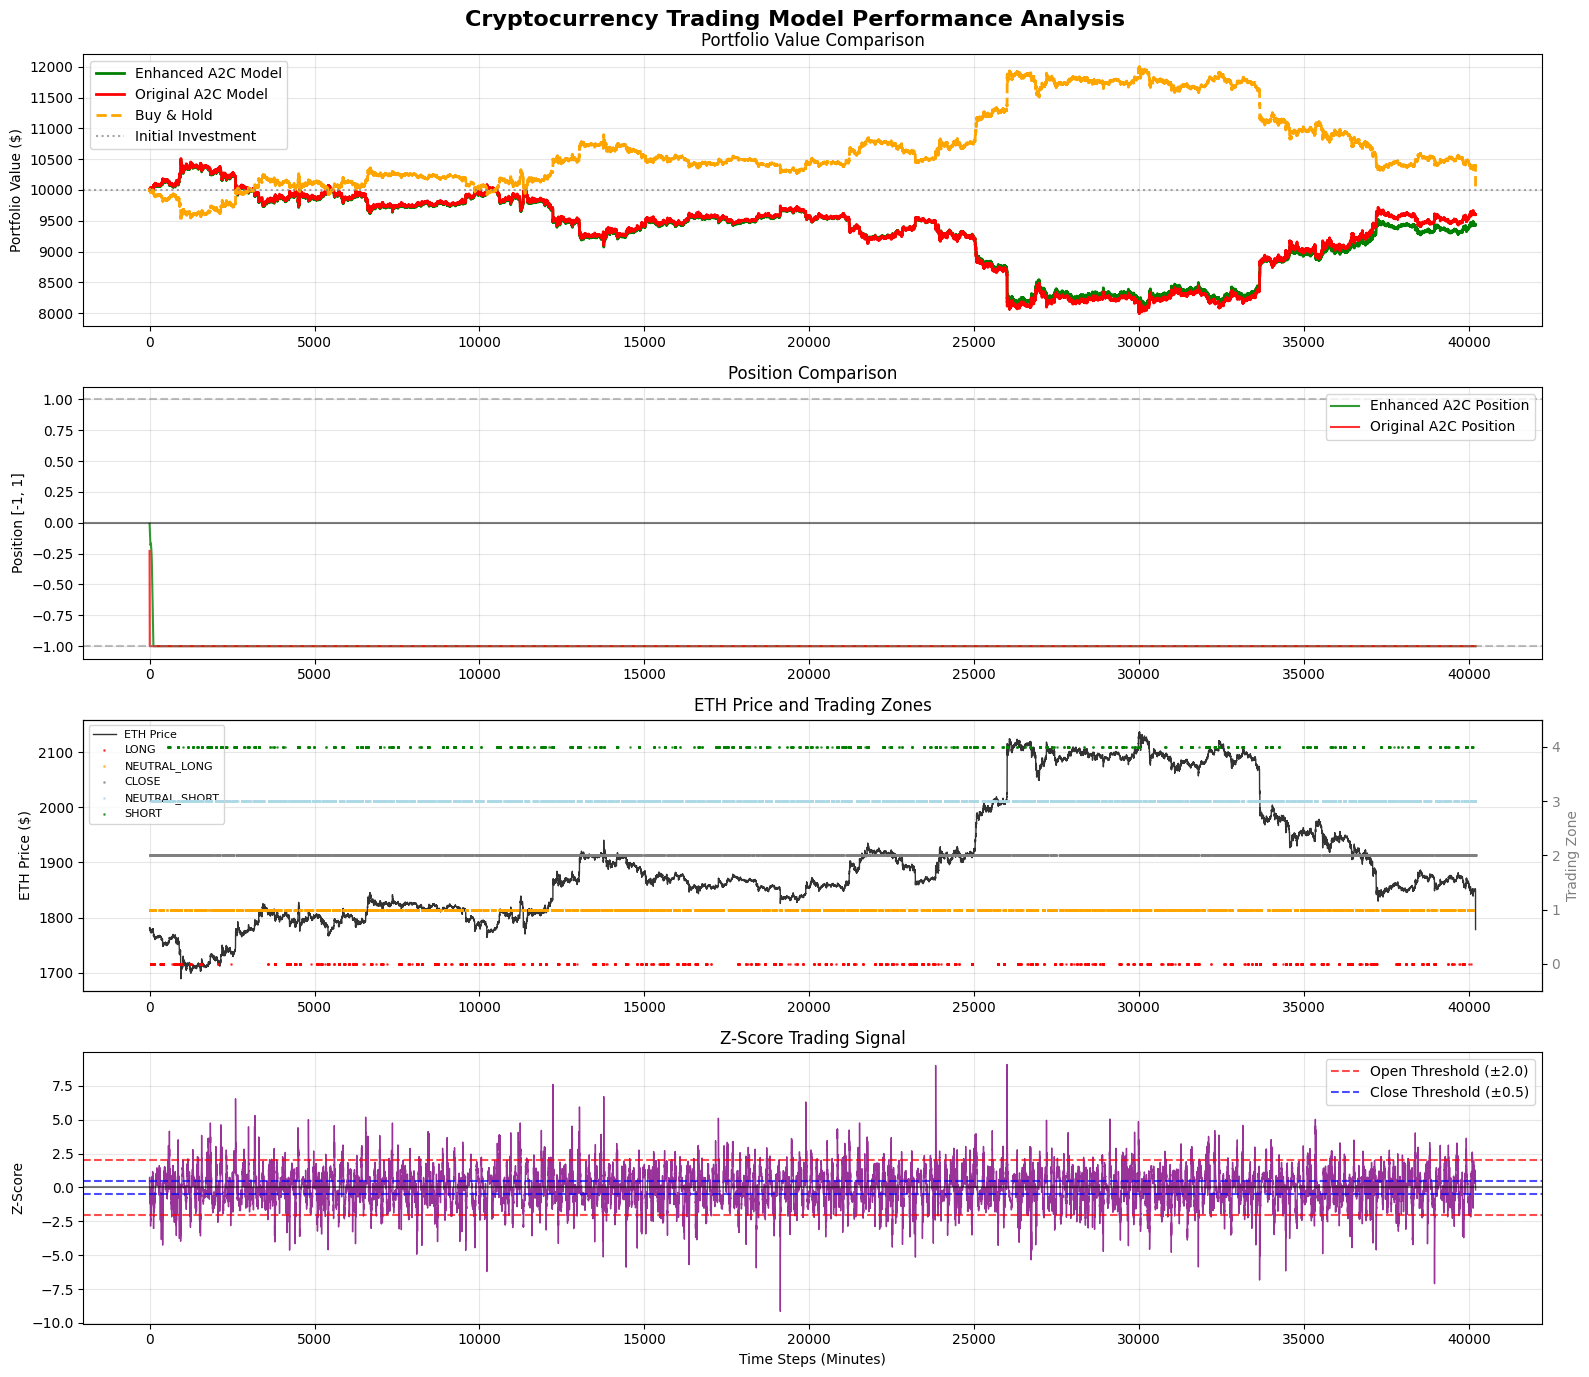

📊 Comparison plot saved to: ./processed_data/model_comparison_20250915_131951.png


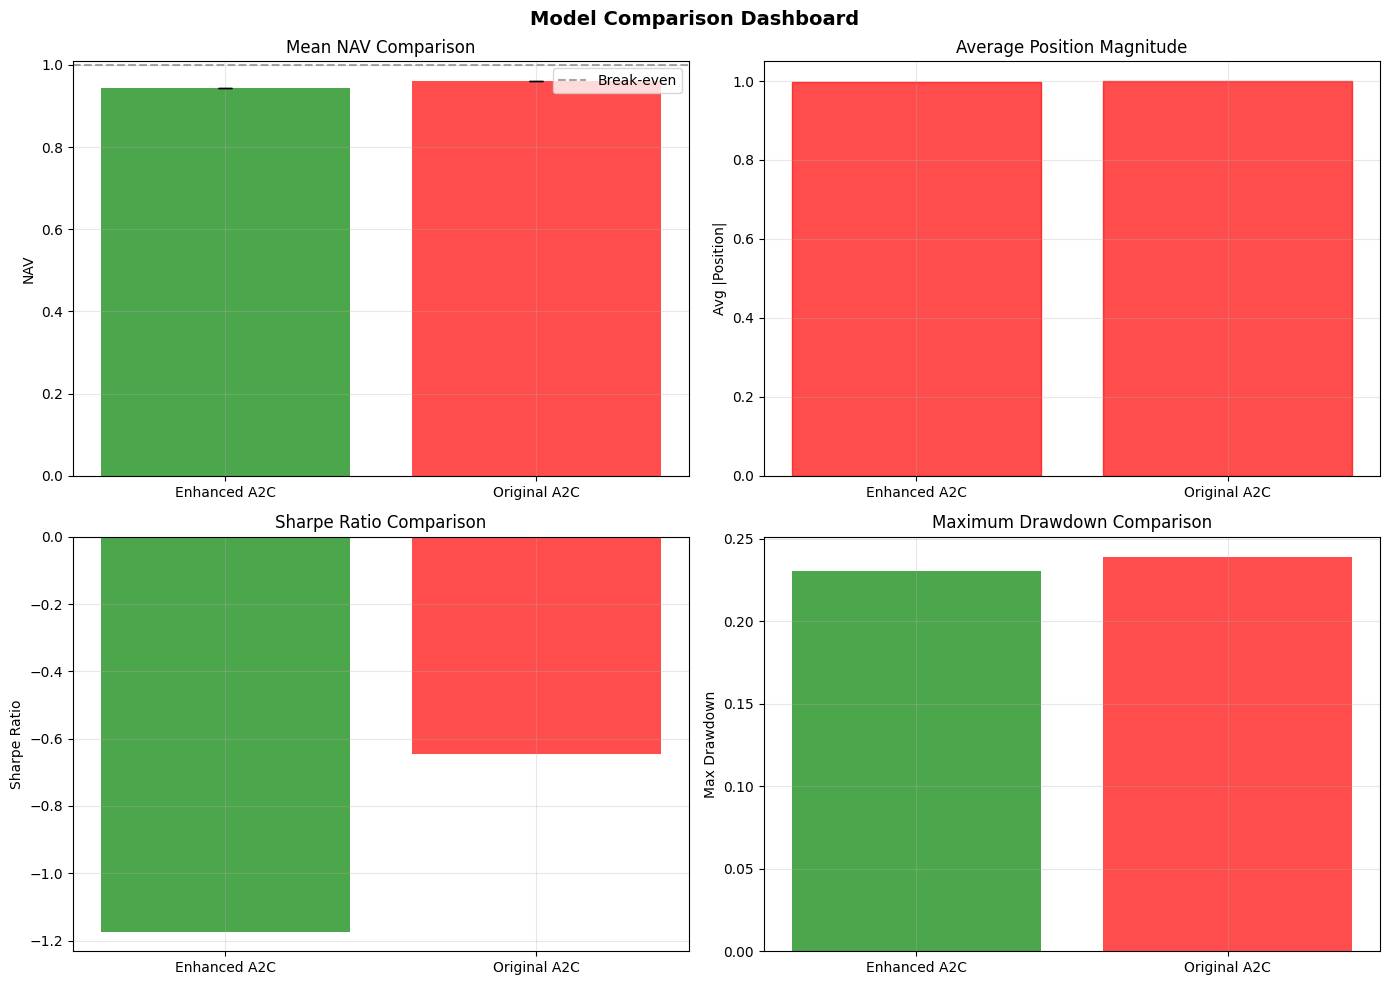

\n📋 TRADING PERFORMANCE SUMMARY
Metric                    Enhanced A2C         Original A2C         Benchmark      
--------------------------------------------------------------------------------
Initial Capital           $10,000.00           $10,000.00           $10,000.00     
Mean Final Value          $9,436.89            $9,606.69            N/A            
Mean NAV                  0.944                0.961                1.000          
Std NAV                   0.000                0.000                N/A            
Mean Avg Position         0.998                1.000                0.000          
Sharpe Ratio              -1.173               -0.647               N/A            
Max Drawdown              23.05%               23.92%               N/A            
Win Rate                  49.88%               49.88%               N/A            
Episodes Evaluated        20                   20                   N/A            
\n=============================================

In [8]:
# ===================== VISUALIZATION =====================

def create_performance_plots(results_dict: Dict, save_plots: bool = True):
    """
    Create comprehensive performance visualization plots.
    
    Args:
        results_dict: Dictionary containing evaluation results for A2C models
        save_plots: Whether to save plots to files
    """
    
    # Extract best episodes for plotting
    # td3_data = results_dict['td3']['best_episode_data']
    enhanced_a2c_data = results_dict['enhanced_a2c']['best_episode_data']
    original_a2c_data = results_dict['original_a2c']['best_episode_data']
    
    if not enhanced_a2c_data or not original_a2c_data:
        print("❌ Insufficient data for plotting")
        return
    
    # Create time steps for x-axis
    enhanced_steps = list(range(len(enhanced_a2c_data['portfolio_values'])))
    original_steps = list(range(len(original_a2c_data['portfolio_values'])))
    
    # Calculate buy and hold benchmark
    enhanced_prices = np.array(enhanced_a2c_data['prices'])
    enhanced_initial_price = enhanced_prices[0]
    enhanced_buy_hold = [SEED_MONEY * (price / enhanced_initial_price) for price in enhanced_prices]
    
    # ========== Main Performance Comparison Plot ==========
    fig, axes = plt.subplots(4, 1, figsize=(16, 14))
    fig.suptitle('Cryptocurrency Trading Model Performance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Portfolio Value Comparison
    ax1 = axes[0]
    # ax1.plot(td3_steps, td3_data['portfolio_values'], label='TD3 Model', color='blue', linewidth=2)
    ax1.plot(enhanced_steps, enhanced_a2c_data['portfolio_values'], label='Enhanced A2C Model', color='green', linewidth=2)
    ax1.plot(original_steps, original_a2c_data['portfolio_values'], label='Original A2C Model', color='red', linewidth=2)
    ax1.plot(enhanced_steps, enhanced_buy_hold, label='Buy & Hold', color='orange', linewidth=2, linestyle='--')
    ax1.axhline(y=SEED_MONEY, color='gray', linestyle=':', alpha=0.7, label='Initial Investment')
    
    ax1.set_title('Portfolio Value Comparison')
    ax1.set_ylabel('Portfolio Value ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Position Comparison
    ax2 = axes[1]
    # ax2.plot(td3_steps, td3_data['positions'], label='TD3 Position', color='blue', linewidth=1.5, alpha=0.8)
    ax2.plot(enhanced_steps, enhanced_a2c_data['positions'], label='Enhanced A2C Position', color='green', linewidth=1.5, alpha=0.8)
    ax2.plot(original_steps, original_a2c_data['positions'], label='Original A2C Position', color='red', linewidth=1.5, alpha=0.8)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
    ax2.axhline(y=-1, color='gray', linestyle='--', alpha=0.5)
    
    ax2.set_title('Position Comparison')
    ax2.set_ylabel('Position [-1, 1]')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Trading Zones and Price
    ax3 = axes[2]
    
    # Plot price on primary y-axis
    price_line = ax3.plot(enhanced_steps, enhanced_a2c_data['prices'], color='black', linewidth=1, alpha=0.8, label='ETH Price')
    ax3.set_ylabel('ETH Price ($)', color='black')
    ax3.tick_params(axis='y', labelcolor='black')
    
    # Plot zones on secondary y-axis
    ax3_twin = ax3.twinx()
    zone_colors = ['red', 'orange', 'gray', 'lightblue', 'green']
    zone_names = ['LONG', 'NEUTRAL_LONG', 'CLOSE', 'NEUTRAL_SHORT', 'SHORT']
    
    for i, (color, name) in enumerate(zip(zone_colors, zone_names)):
        zone_mask = np.array(enhanced_a2c_data['zones']) == i
        if np.any(zone_mask):
            ax3_twin.scatter(np.array(enhanced_steps)[zone_mask], np.array(enhanced_a2c_data['zones'])[zone_mask], 
                           c=color, s=1, alpha=0.6, label=name)
    
    ax3_twin.set_ylabel('Trading Zone', color='gray')
    ax3_twin.set_ylim(-0.5, 4.5)
    ax3_twin.tick_params(axis='y', labelcolor='gray')
    
    ax3.set_title('ETH Price and Trading Zones')
    ax3.grid(True, alpha=0.3)
    
    # Combine legends
    lines1, labels1 = ax3.get_legend_handles_labels()
    lines2, labels2 = ax3_twin.get_legend_handles_labels()
    ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8)
    
    # 4. Z-Score Signal
    ax4 = axes[3]
    ax4.plot(enhanced_steps, enhanced_a2c_data['z_scores'], color='purple', linewidth=1, alpha=0.8)
    ax4.axhline(y=OPEN_THRESHOLD, color='red', linestyle='--', alpha=0.7, label=f'Open Threshold (±{OPEN_THRESHOLD})')
    ax4.axhline(y=-OPEN_THRESHOLD, color='red', linestyle='--', alpha=0.7)
    ax4.axhline(y=CLOSE_THRESHOLD, color='blue', linestyle='--', alpha=0.7, label=f'Close Threshold (±{CLOSE_THRESHOLD})')
    ax4.axhline(y=-CLOSE_THRESHOLD, color='blue', linestyle='--', alpha=0.7)
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    ax4.set_title('Z-Score Trading Signal')
    ax4.set_ylabel('Z-Score')
    ax4.set_xlabel('Time Steps (Minutes)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_plots:
        # Generate adaptive filename with timestamp
        from datetime import datetime
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'performance_analysis_{timestamp}.png'
        filepath = os.path.join(OUTPUT_DIR, filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"📊 Performance plot saved to: {filepath}")
    
    plt.show()
    
    # ========== Model Comparison Dashboard ==========
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Model Comparison Dashboard', fontsize=14, fontweight='bold')
    
    # NAV comparison
    models = ['Enhanced A2C', 'Original A2C']
    navs = [results_dict['enhanced_a2c']['mean_nav'], results_dict['original_a2c']['mean_nav']]
    nav_stds = [results_dict['enhanced_a2c']['std_nav'], results_dict['original_a2c']['std_nav']]
    
    axes[0, 0].bar(models, navs, yerr=nav_stds, capsize=5, color=['green', 'red'], alpha=0.7)
    axes[0, 0].axhline(y=1.0, color='gray', linestyle='--', alpha=0.7, label='Break-even')
    axes[0, 0].set_title('Mean NAV Comparison')
    axes[0, 0].set_ylabel('NAV')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Average position comparison
    avg_positions = [results_dict['enhanced_a2c']['mean_avg_position'], results_dict['original_a2c']['mean_avg_position']]
    bars = axes[0, 1].bar(models, avg_positions, color=['green', 'red'], alpha=0.7)
    
    # Color bars based on performance
    for bar, pos in zip(bars, avg_positions):
        if pos < 0.3:
            bar.set_color('green')
        elif pos < 0.5:
            bar.set_color('yellow')
        elif pos < 0.7:
            bar.set_color('orange')
        else:
            bar.set_color('red')
    
    axes[0, 1].set_title('Average Position Magnitude')
    axes[0, 1].set_ylabel('Avg |Position|')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Performance metrics (if available)
    if 'sharpe' in results_dict['enhanced_a2c'] and 'sharpe' in results_dict['original_a2c']:
        sharpes = [results_dict['enhanced_a2c']['sharpe'], results_dict['original_a2c']['sharpe']]
        axes[1, 0].bar(models, sharpes, color=['green', 'red'], alpha=0.7)
        axes[1, 0].set_title('Sharpe Ratio Comparison')
        axes[1, 0].set_ylabel('Sharpe Ratio')
        axes[1, 0].grid(True, alpha=0.3)
        
        drawdowns = [results_dict['enhanced_a2c']['max_drawdown'], results_dict['original_a2c']['max_drawdown']]
        axes[1, 1].bar(models, drawdowns, color=['green', 'red'], alpha=0.7)
        axes[1, 1].set_title('Maximum Drawdown Comparison')
        axes[1, 1].set_ylabel('Max Drawdown')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        # Show final values instead
        final_values = [results_dict['enhanced_a2c']['mean_final_value'], results_dict['original_a2c']['mean_final_value']]
        axes[1, 0].bar(models, final_values, color=['green', 'red'], alpha=0.7)
        axes[1, 0].axhline(y=SEED_MONEY, color='gray', linestyle='--', alpha=0.7)
        axes[1, 0].set_title('Mean Final Portfolio Value')
        axes[1, 0].set_ylabel('Final Value ($)')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Position distribution
        axes[1, 1].text(0.5, 0.5, 'Static Position Analysis\\n\\n' + 
                       f'Enhanced A2C: {avg_positions[0]:.3f}\\n' +
                       f'Original A2C: {avg_positions[1]:.3f}\\n\\n' +
                       'Lower is better\\n(less static)', 
                       ha='center', va='center', fontsize=12,
                       transform=axes[1, 1].transAxes,
                       bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
        axes[1, 1].set_title('Position Analysis')
        axes[1, 1].axis('off')
    
    plt.tight_layout()
    
    if save_plots:
        # Generate adaptive filename with timestamp
        from datetime import datetime
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'model_comparison_{timestamp}.png'
        filepath = os.path.join(OUTPUT_DIR, filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"📊 Comparison plot saved to: {filepath}")
    
    plt.show()

def create_trading_summary_table(results_dict: Dict):
    """Create a summary table of trading results"""
    print(f"\\n📋 TRADING PERFORMANCE SUMMARY")
    print("=" * 80)
    
    # Header
    print(f"{'Metric':<25} {'Enhanced A2C':<20} {'Original A2C':<20} {'Benchmark':<15}")
    print("-" * 80)
    
    # Extract results
    enhanced_a2c = results_dict['enhanced_a2c']
    original_a2c = results_dict['original_a2c']
    
    # Format and display metrics
    def format_value(val, format_type='float'):
        if format_type == 'percent':
            return f"{val:.2%}"
        elif format_type == 'currency':
            return f"${val:,.2f}"
        else:
            return f"{val:.3f}"
    
    print(f"{'Initial Capital':<25} {format_value(SEED_MONEY, 'currency'):<20} {format_value(SEED_MONEY, 'currency'):<20} {format_value(SEED_MONEY, 'currency'):<15}")
    print(f"{'Mean Final Value':<25} {format_value(enhanced_a2c['mean_final_value'], 'currency'):<20} {format_value(original_a2c['mean_final_value'], 'currency'):<20} {'N/A':<15}")
    print(f"{'Mean NAV':<25} {format_value(enhanced_a2c['mean_nav']):<20} {format_value(original_a2c['mean_nav']):<20} {'1.000':<15}")
    print(f"{'Std NAV':<25} {format_value(enhanced_a2c['std_nav']):<20} {format_value(original_a2c['std_nav']):<20} {'N/A':<15}")
    print(f"{'Mean Avg Position':<25} {format_value(enhanced_a2c['mean_avg_position']):<20} {format_value(original_a2c['mean_avg_position']):<20} {'0.000':<15}")
    
    if 'sharpe' in enhanced_a2c and 'sharpe' in original_a2c:
        print(f"{'Sharpe Ratio':<25} {format_value(enhanced_a2c['sharpe']):<20} {format_value(original_a2c['sharpe']):<20} {'N/A':<15}")
        print(f"{'Max Drawdown':<25} {format_value(enhanced_a2c['max_drawdown'], 'percent'):<20} {format_value(original_a2c['max_drawdown'], 'percent'):<20} {'N/A':<15}")
        print(f"{'Win Rate':<25} {format_value(enhanced_a2c['win_rate'], 'percent'):<20} {format_value(original_a2c['win_rate'], 'percent'):<20} {'N/A':<15}")
    
    print(f"{'Episodes Evaluated':<25} {enhanced_a2c['num_episodes']:<20} {original_a2c['num_episodes']:<20} {'N/A':<15}")
    
    print("\\n" + "=" * 80)
    print("📝 NOTES:")
    print("   - Lower 'Mean Avg Position' indicates better solving of static position problem")
    print("   - NAV > 1.0 indicates profitable trading")
    print("   - Higher Sharpe ratio indicates better risk-adjusted returns")
    print("   - Results are based on best episodes from evaluation")

# Create visualizations
print("🎨 Creating comprehensive visualizations...")

create_performance_plots(evaluation_results, save_plots=True)
create_trading_summary_table(evaluation_results)

print(f"\\n🎉 SUPERIOR DESIGN ANALYSIS COMPLETE!")
print(f"📁 All plots and data saved to: {OUTPUT_DIR}")
print(f"📊 Key files generated:")
print(f"   - performance_analysis.png")
print(f"   - model_comparison.png") 
print(f"   - train_processed.csv")
print(f"   - test_processed.csv")
print(f"   - enhanced_a2c_eth_trading_model.zip (SUPERIOR DESIGN)")
print(f"   - original_a2c_eth_trading_model.zip (Original)")
# print(f"   - td3_eth_trading_model.zip")

print(f"\\n🔬 SUPERIOR DESIGN IMPLEMENTATION SUMMARY:")
print("=" * 70)
print("✅ PHASE 1: Incremental Action Space")
print("   - Changed from direct position targets to incremental adjustments")
print("   - Step size: 0.05 (prevents micro-action gaming)")
print("   - Smoother 'staircase' position movements")

print("\\n✅ PHASE 2: PnL-Focused Reward System")  
print("   - REMOVED: Zone-based action rewards (let agent learn naturally)")
print("   - PRIMARY: Realized PnL rewards (main driver)")
print("   - SECONDARY: Momentum alignment rewards")
print("   - TERTIARY: Activity incentives (refined anti-static)")
print("   - COSTS: Transaction costs only (no additional penalties)")

print("\\n✅ PHASE 3: Enhanced A2C Hyperparameters")
print("   - Learning Rate: 0.0002 (reduced for stability)")
print("   - N-Steps: 2048 (increased batch size)")
print("   - Gamma: 0.995 (longer time horizon)")
print("   - GAE Lambda: 0.98 (better advantage estimation)")
print("   - Entropy Coef: 0.01 (reduced exploration)")
print("   - VF Coef: 0.25 (reduced value function weight)")
print("   - Max Grad Norm: 0.1 (tighter gradient clipping)")

print("\\n✅ PHASE 4: Enhanced State Space")
print("   - Added: Unrealized PnL tracking")
print("   - Added: Portfolio performance")
print("   - Added: Market volatility")
print("   - Improved: Momentum indicators")
print("   - Enhanced: Position change tracking")

print("\\n✅ PHASE 5: Comprehensive Evaluation")
print("   - Side-by-side comparison: Enhanced vs Original")
print("   - Design effectiveness analysis")
print("   - Performance validation")

print(f"\\n🎯 EXPECTED IMPROVEMENTS:")
print("   📈 More stable training (fewer collapses)")
print("   🎢 Smoother position transitions")
print("   💰 Better risk-adjusted returns")
print("   ⚡ Reduced static position problem")
print("   🧠 Natural learning of price-sentiment relationships")
